In [7]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [8]:
# Grab spectra_LES.nc
ds = xr.open_dataset(Path("data_original/spectra_LES.nc"))

In [9]:
radius_ds = ds['radius']
height_ds = ds['height']
frequency_ds = ds['frequency']
spectralDensity_UU_ds = ds['spectralDensity_uu']
spectralDensity_VV_ds = ds['spectralDensity_vv']
spectralDensity_WW_ds = ds['spectralDensity_ww']
spectralDensity_UW_ds = ds['spectralDensity_uw']


In [10]:
print(radius_ds.shape)
print(height_ds.shape)
print(frequency_ds.shape)
print(spectralDensity_UU_ds.shape)
print(spectralDensity_VV_ds.shape)
print(spectralDensity_WW_ds.shape)
print(spectralDensity_UW_ds.shape)

(1,)
(60,)
(3001,)
(1, 60, 3001)
(1, 60, 3001)
(1, 60, 3001)
(1, 60, 3001)


In [11]:
radius = np.array(ds['radius'])
height = np.array(ds['height'])
frequency = np.array(ds['frequency'])

# spectralDensity_UV = np.array(ds['spectralDensity_UV']).squeeze()
spectralDensity_UU = np.array(ds['spectralDensity_uu']).squeeze()
spectralDensity_VV = np.array(ds['spectralDensity_vv']).squeeze()
spectralDensity_WW = np.array(ds['spectralDensity_ww']).squeeze()
spectralDensity_UW = np.array(ds['spectralDensity_uw']).squeeze()

ds.close()

In [12]:
height[30]

np.float64(148.56202535609793)

In [13]:
print(spectralDensity_UU.shape)
print(spectralDensity_VV.shape)
print(spectralDensity_WW.shape)
print(spectralDensity_UW.shape)

(60, 3001)
(60, 3001)
(60, 3001)
(60, 3001)


In [14]:
# Fix a height...
i = 30
h = height[i]

# Get the spectra at that height
frequency_h = frequency.copy()
spectralDensity_UU_h = np.squeeze(spectralDensity_UU[i, :])
spectralDensity_VV_h = np.squeeze(spectralDensity_VV[i, :])
spectralDensity_WW_h = np.squeeze(spectralDensity_WW[i, :])
spectralDensity_UW_h = np.squeeze(spectralDensity_UW[i, :])

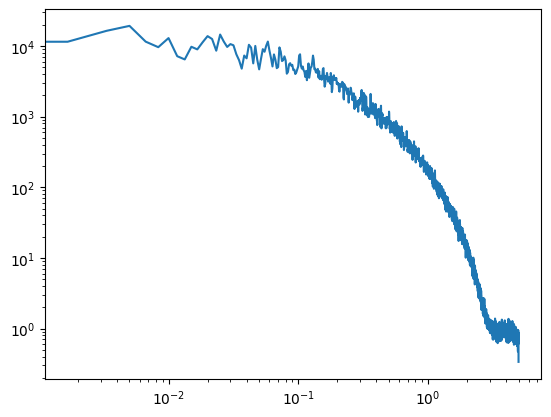

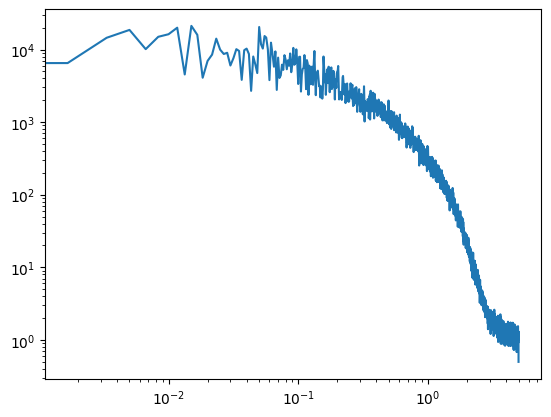

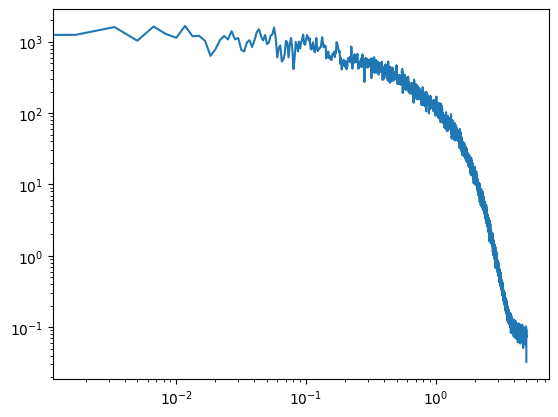

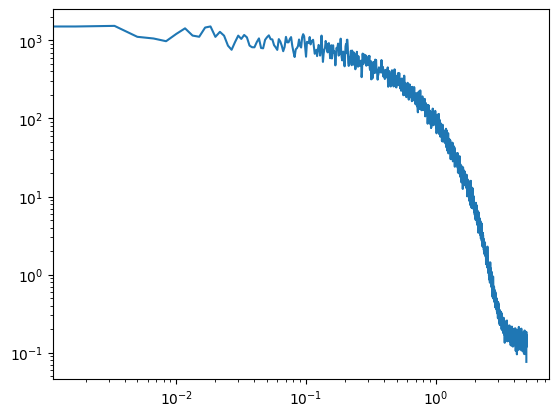

In [15]:
plt.loglog(frequency_h, spectralDensity_UU_h)
plt.show()
plt.figure()
plt.loglog(frequency_h, spectralDensity_VV_h)
plt.show()
plt.figure()
plt.loglog(frequency_h, spectralDensity_WW_h)
plt.show()
plt.figure()
plt.loglog(frequency_h, spectralDensity_UW_h)

In [16]:
def clean_spectra(frequency, uu, vv, ww, uw, threshold=1.0, buffer_points=10):
    """
    Clean all spectral components using a common cutoff point.
    
    Parameters
    ----------
    frequency : np.ndarray
        The frequency values (3001,)
    uu, vv, ww, uw : np.ndarray
        The spectral components (each 3001,)
    threshold : float, optional
        The threshold value below which to cut off (default: 1.0)
    buffer_points : int, optional
        Number of points to keep before the cutoff for smooth transition
        
    Returns
    -------
    cleaned_freq : np.ndarray
        The cleaned frequency array
    cleaned_uu, cleaned_vv, cleaned_ww, cleaned_uw : np.ndarray
        The cleaned spectral components
    """
    # Find where each component drops below threshold
    cutoff_idx_uu = np.where(uu < threshold)[0][0] if np.any(uu < threshold) else len(uu)
    cutoff_idx_vv = np.where(vv < threshold)[0][0] if np.any(vv < threshold) else len(vv)
    cutoff_idx_ww = np.where(ww < threshold)[0][0] if np.any(ww < threshold) else len(ww)
    
    # For uw (cross-spectrum), use absolute value since it can be negative
    cutoff_idx_uw = np.where(np.abs(uw) < threshold/10)[0][0] if np.any(np.abs(uw) < threshold/10) else len(uw)
    
    # Take the earliest cutoff point to ensure all spectra are valid
    cutoff_idx = min(cutoff_idx_uu, cutoff_idx_vv, cutoff_idx_ww, cutoff_idx_uw)
    
    # Add buffer
    final_idx = max(0, cutoff_idx - buffer_points)
    
    # Return cleaned arrays
    return (frequency[:final_idx],
            uu[:final_idx],
            vv[:final_idx],
            ww[:final_idx],
            uw[:final_idx])

In [17]:
cleaned_freq, cleaned_uu, cleaned_vv, cleaned_ww, cleaned_uw = clean_spectra(
    frequency_h,
    spectralDensity_UU_h,
    spectralDensity_VV_h,
    spectralDensity_WW_h,
    spectralDensity_UW_h
)

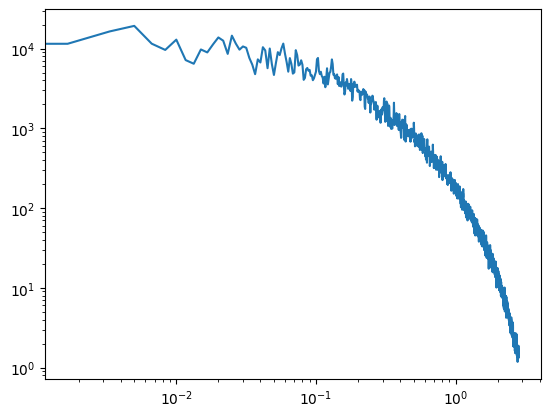

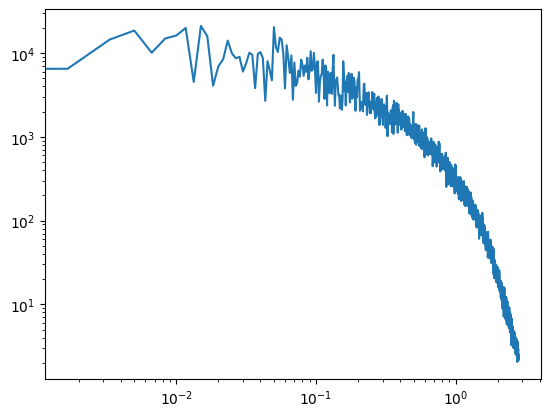

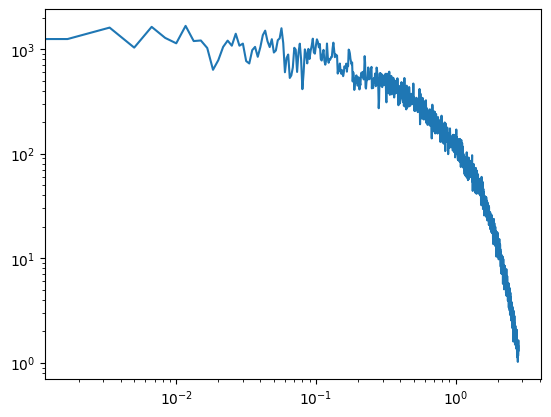

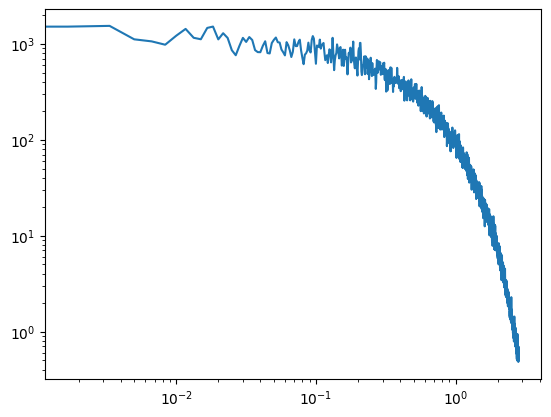

In [18]:
plt.loglog(cleaned_freq, cleaned_uu)
plt.show()
plt.figure()
plt.loglog(cleaned_freq, cleaned_vv)
plt.show()
plt.figure()
plt.loglog(cleaned_freq, cleaned_ww)
plt.show()
plt.figure()
plt.loglog(cleaned_freq, cleaned_uw)

In [19]:
weighted_uu = cleaned_uu * cleaned_freq
weighted_vv = cleaned_vv * cleaned_freq
weighted_ww = cleaned_ww * cleaned_freq
weighted_uw = cleaned_uw * cleaned_freq


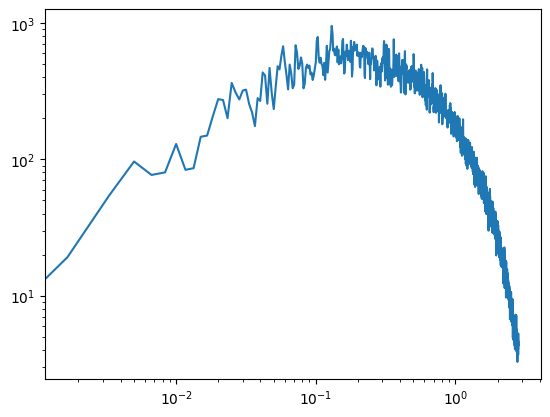

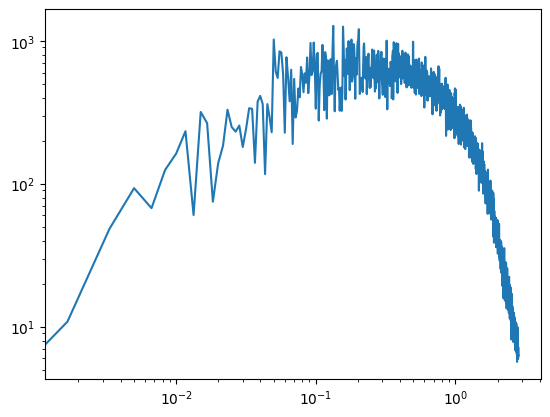

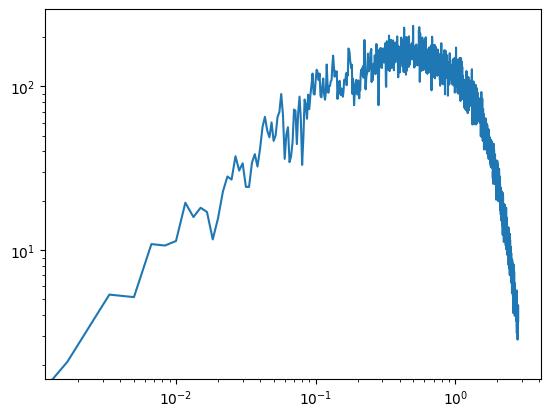

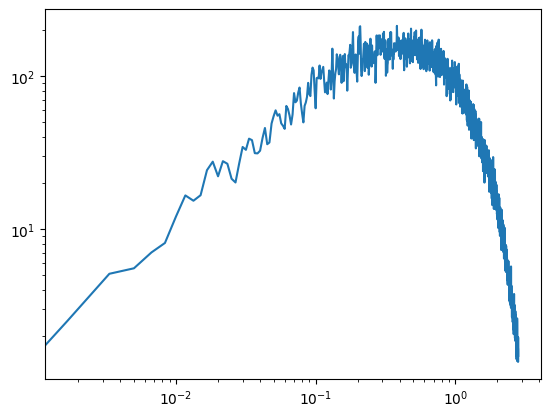

In [20]:
plt.loglog(cleaned_freq, weighted_uu)
plt.show()
plt.figure()
plt.loglog(cleaned_freq, weighted_vv)
plt.show()
plt.figure()
plt.loglog(cleaned_freq, weighted_ww)
plt.show()
plt.figure()
plt.loglog(cleaned_freq, weighted_uw)

In [31]:
def log_downsample(freq, data_columns, points_per_decade=20):
    """Downsample data with logarithmic spacing."""
    # Ensure all inputs are numpy arrays
    freq = np.array(freq)
    data_arrays = [np.array(col) for col in data_columns]
    
    # Filter out any zero or negative values in frequency
    positive_mask = freq > 0
    if not np.all(positive_mask):
        freq = freq[positive_mask]
        data_arrays = [col[positive_mask] for col in data_arrays]
        
    # Calculate frequency decades (log10 ranges)
    min_freq, max_freq = np.min(freq), np.max(freq)
    
    # Add a small epsilon to min_freq to prevent log10(0)
    min_freq = max(min_freq, 1e-10)
    
    min_decade, max_decade = np.log10(min_freq), np.log10(max_freq)
    num_decades = max_decade - min_decade
    
    # Ensure num_decades is positive
    if num_decades <= 0:
        num_decades = 1.0  # Default to at least one decade
    
    # Calculate total number of points to keep
    total_points = int(np.ceil(points_per_decade * num_decades))
    
    # Ensure we have at least 2 points
    total_points = max(total_points, 2)
    
    # Create logarithmically spaced frequency points
    log_spaced_freq = np.logspace(min_decade, max_decade, total_points)
    
    # Find indices of original data points closest to these log-spaced points
    downsampled_indices = []
    for target_freq in log_spaced_freq:
        idx = np.argmin(np.abs(freq - target_freq))
        if idx not in downsampled_indices:  # Avoid duplicates
            downsampled_indices.append(idx)
    
    # Sort indices
    downsampled_indices.sort()
    
    # Return downsampled frequency and data arrays
    downsampled_freq = freq[downsampled_indices]
    downsampled_data = [col[downsampled_indices] for col in data_arrays]
    
    return downsampled_freq, downsampled_data

downsampled_freq, downsampled_data = log_downsample(
    cleaned_freq, 
    [weighted_uu, weighted_vv, weighted_ww, weighted_uw],
    points_per_decade=50  # Adjust this
)

In [32]:
downsampled_freq.shape

(116,)

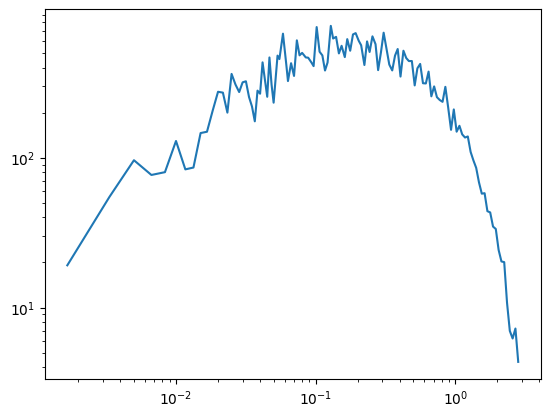

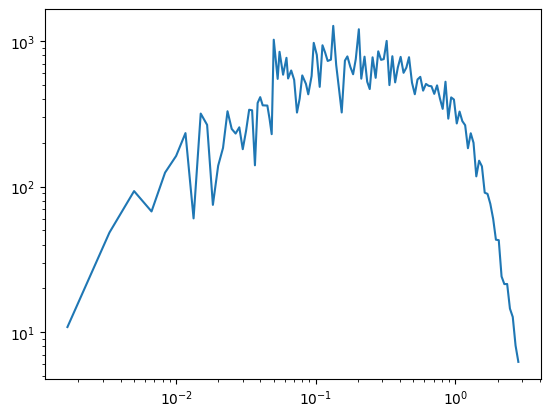

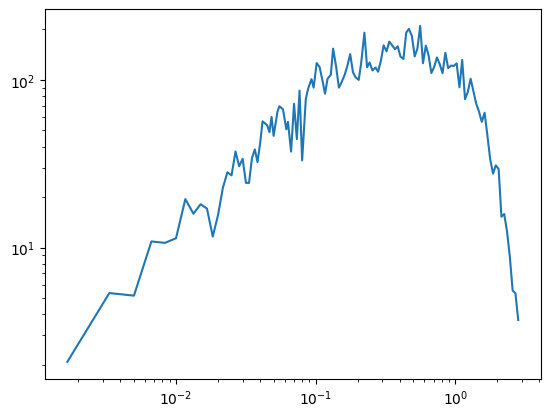

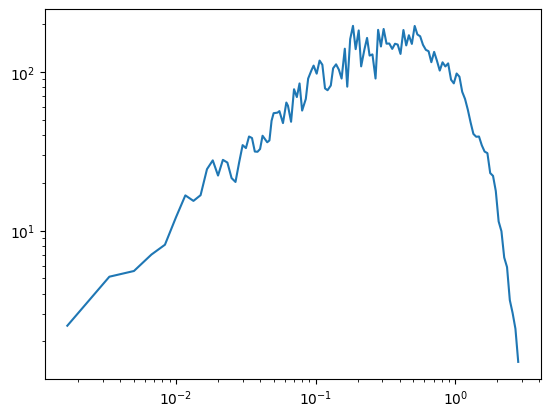

In [33]:
plt.loglog(downsampled_freq, downsampled_data[0])
plt.show()
plt.figure()
plt.loglog(downsampled_freq, downsampled_data[1])
plt.show()
plt.figure()
plt.loglog(downsampled_freq, downsampled_data[2])
plt.show()
plt.figure()
plt.loglog(downsampled_freq, downsampled_data[3])

In [36]:
downsampled_data_array = np.column_stack([downsampled_freq] + downsampled_data)
downsampled_data_array.shape

(116, 5)

In [37]:
np.savetxt('data_cleaned/log_downsampled_data.dat', 
    downsampled_data_array,
    delimiter = ","
)

In [23]:
# NOTE: OLD
full_data = np.column_stack((cleaned_freq, weighted_uu, weighted_vv, weighted_ww, weighted_uw))
full_data.shape
# Take 1/4 of the data, evenly spaced over the range
quarter_data = full_data[::4, :]
quarter_data.shape

(424, 5)

In [24]:
print(quarter_data)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [6.66666667e-03 7.67578184e+01 6.75093297e+01 1.08729250e+01
  7.05627749e+00]
 [1.33333333e-02 8.60393270e+01 6.04818345e+01 1.59072825e+01
  1.53781000e+01]
 ...
 [2.80666667e+00 4.05021812e+00 6.53028660e+00 3.70653506e+00
  1.37902948e+00]
 [2.81333333e+00 4.40275909e+00 6.83227650e+00 4.61232421e+00
  1.35870574e+00]
 [2.82000000e+00 4.33818787e+00 6.25105896e+00 3.69352616e+00
  1.48741615e+00]]


In [ ]:
np.savetxt('data_cleaned/cleaned_weighted_spectra_quarter.dat', 
    quarter_data,
    delimiter = ","
)

In [18]:
np.savetxt('data_cleaned/cleaned_weighted_spectra.dat', 
    np.column_stack((cleaned_freq, weighted_uu, weighted_vv, weighted_ww, weighted_uw)),
    delimiter = ","
)